# **Install important liberaries**

In [1]:
!pip install wordcloud
!pip install nltk
!pip install palettable
!pip install clean-text
!pip install datasets
!pip install --upgrade pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.1 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=e9d4871fef91c320fcdcffd71491e25c784367aa5991a486962ce4aaf5ac9259
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
   

# **Libraries**

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re
import torch
from functools import partial
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from datasets import load_dataset
import matplotlib.pyplot as plt
from cleantext import clean
import string
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Concatenate, Bidirectional, Conv1D, MaxPool1D, Flatten, Embedding, Input, Dropout, concatenate, GlobalAveragePooling1D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **load dataset**

In [3]:
dataset = pd.read_csv("/content/Emotion_final.csv")

In [4]:
dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# **Exploratory Data Analysis**

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [6]:
dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
pd.DataFrame(dataset['Emotion'].value_counts()).rename(columns={'Emotion': 'Count'})

,count
Emotion,
happy,7029
sadness,6265
anger,2993
fear,2652
love,1641
surprise,879


**Number of duplicate sentence**

In [8]:
pd.DataFrame({'Count': [dataset['Text'].duplicated().sum()]})

,Count
0,54


In [9]:
dataset.drop_duplicates(subset='Text', inplace=True)
dataset.dropna(subset=['Text'], inplace=True)

In [10]:
pd.DataFrame({'Count': [dataset['Text'].duplicated().sum()]})

,Count
0,0


In [11]:
pd.DataFrame(dataset['Emotion'].value_counts()).rename(columns={'Emotion': 'Count'})

,count
Emotion,
happy,7008
sadness,6261
anger,2986
fear,2647
love,1630
surprise,873


**build class to make visualization to data:**

The `Analysis` class visualizes and summarizes categorical data from a pandas DataFrame. It initializes with a customizable figure size, and offers methods to plot bar and pie charts, create a summary DataFrame of counts, and display both charts and summaries via a callable interface.



-------------------------------------------------------


,0,1,2,3,4,5
emotion,happy,sadness,anger,fear,love,surprise
count,7008,6261,2986,2647,1630,873


-------------------------------------------------------


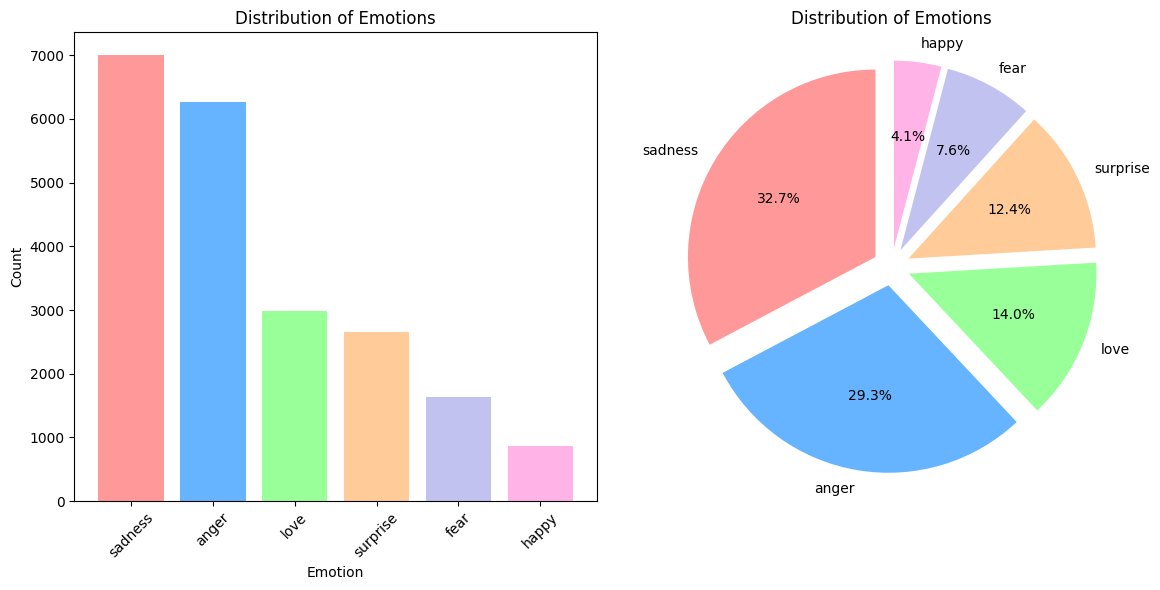

In [12]:
class Analysis():
    def __init__(self, figsize=(12, 6)):
        self.figsize = figsize

    def plot_bar_pie_chart(self, dataframe, column_name, explode, colors):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=self.figsize)
        labels = list(dataframe[column_name].unique())
        sizes = list(dataframe[column_name].value_counts())

        ax1.bar(labels, sizes, color=colors)
        ax1.set_title('Distribution of Emotions')
        ax1.set_xlabel('Emotion')
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45)

        ax2.pie(sizes, labels=labels,explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Distribution of Emotions')


        plt.tight_layout()
        plt.show()

    def create_label_counts_df(self, dataframe, column_name):

        label_counts_df = dataframe[column_name].value_counts().reset_index()
        label_counts_df.columns = ['emotion', 'count']
        return label_counts_df.transpose()

    def __call__ (self, dataframe, column_name, explode, colors):
        print("-"*55)
        display(self.create_label_counts_df(dataframe, column_name))
        print("-"*55)
        self.plot_bar_pie_chart(dataframe, column_name, explode, colors)

analysis = Analysis(figsize=(12, 6))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
analysis(dataset, 'Emotion', explode, colors)

In [13]:
dataset.to_csv("train.csv", index=False)

# **Pipeline for Preprocessing and train model an Emotion Classification Model**

This Colab cell defines and runs a pipeline for preparing a dataset, cleaning text data, and training a model for emotion classification. The pipeline includes:

1.   Data Import: Load data from a CSV file

2.   Data Cleaning: Apply text processing techniques such as

  *   lowercasing
  *   removing special characters
  *   removing stop words
  *   removing numbers
  *   removing emojis
  *   removing rare words
  *   removing extra
  *   removing empty strings

3.   Data Preprocessing: Tokenize the text and split the data into training, validation, and test sets. Encode the target labels.
4.   Model Training: Train a model with the processed data and evaluate its performance.

The pipeline culminates with saving the trained model. Use the pipeline with your dataset path and model to execute the entire process.


## **Define our functions data importer, data cleaner, data preprocessing, moder trainer and evaluation**

In [131]:
def data_importer(path):
    # Read the CSV file
    dataset = pd.read_csv(path)

    # Print success message and dataset preview
    print("=" * 50)
    print("Step 1: The data loaded successfully :)")
    print("=" * 50)
    print(dataset.head(5))  # Display the first 5 rows of the dataset

    return dataset

In [132]:
def data_cleaner(input_column_name, target_column_name, dataset):
    """
    Cleans the specified text column in a pandas DataFrame using a series of text preprocessing steps.

    Parameters:
    - input_column_name (str): The name of the column in the DataFrame to clean.
    - target_column_name (str): The name of the target column, which is checked for existence but not modified.
    - dataset (pd.DataFrame): The DataFrame containing the data to be cleaned.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """

    # Ensure that the dataset is a pandas DataFrame
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("The dataset should be a pandas DataFrame.")

    # Load NLTK stopwords
    stopwords_list = set(stopwords.words('english'))

    # Define a list of negation words to be preserved
    negation_words = {'not', 'no', 'never', 'none', 'nothing', 'nobody', 'nowhere', 'neither', 'nor',
                      'don\'t', 'doesn\'t', 'didn\'t', 'can\'t', 'won\'t', 'wouldn\'t', 'shouldn\'t', 'mustn\'t'}

    # Convert text to lowercase
    def to_lower_case(examples):
        return examples.str.lower()

    # Remove stop words from the text, preserving negation words
    def remove_stop_words(data, stopwords_list, negation_words):
        return data.apply(lambda text: ' '.join(word for word in text.split() if word.lower() not in stopwords_list or word.lower() in negation_words))

    # Remove special characters from the text
    def remove_special_characters(examples):
        return examples.apply(lambda text: re.sub(r'[^\w\s]', '', text))

    # Remove numbers from the text
    def remove_numbers(examples):
        return examples.apply(lambda text: re.sub(r'\d+', '', text))

    # Remove emojis from the text
    def remove_emojis(examples):
        return examples.apply(lambda text: text.encode('ascii', 'ignore').decode('ascii'))

    # Remove single characters from the text
    def remove_single_characters(examples):
        return examples.apply(lambda text: re.sub(r'\b\w\b', '', text).strip())

    # Remove repeated letters (e.g., "loooove" -> "love")
    def remove_repeated_letters(examples):
        return examples.apply(lambda text: re.sub(r'([a-zA-Z])\1{2,}', r'\1', text))

    # Remove extra spaces from the text
    def remove_extra_spaces(examples):
        return examples.apply(lambda text: ' '.join(text.split()))

    # Remove rare words that occur fewer than a specified number of times
    def remove_rare_words(examples, min_freq=10):
        all_words = [word for text in examples for word in text.split()]
        word_counts = Counter(all_words)
        return examples.apply(lambda text: ' '.join(word for word in text.split() if word_counts[word] >= min_freq))

    # Validate that the specified columns exist in the dataset
    if input_column_name not in dataset.columns or target_column_name not in dataset.columns:
        raise ValueError(f"Column '{input_column_name}' or '{target_column_name}' not found in dataset.")

    # Apply each text cleaning function in sequence
    dataset[input_column_name] = to_lower_case(dataset[input_column_name])
    dataset[input_column_name] = remove_special_characters(dataset[input_column_name])
    dataset[input_column_name] = remove_numbers(dataset[input_column_name])
    dataset[input_column_name] = remove_emojis(dataset[input_column_name])
    dataset[input_column_name] = remove_stop_words(dataset[input_column_name], stopwords_list, negation_words)
    dataset[input_column_name] = remove_rare_words(dataset[input_column_name], min_freq=10)
    dataset[input_column_name] = remove_extra_spaces(dataset[input_column_name])
    dataset[input_column_name] = remove_single_characters(dataset[input_column_name])
    dataset[input_column_name] = remove_repeated_letters(dataset[input_column_name])

    # Remove rows where the cleaned text column is empty
    dataset = dataset[dataset[input_column_name].str.strip() != ''].reset_index(drop=True)

    # Print a success message and a preview of the cleaned dataset
    print("=" * 50)
    print("Step 2: The data was cleaned successfully :)")
    print("=" * 50)
    print(dataset.head(5))

    return dataset

In [133]:
def data_preprocessor(input_column_name, target_column_name, dataset, num_words, oov_token, type_padding, type_truncating, maxlen):
    """
    Preprocesses text data by tokenizing, padding sequences, and encoding labels.

    Args:
        input_column_name (str): The column name in the dataset containing the input text data.
        target_column_name (str): The column name in the dataset containing the target labels.
        dataset (pd.DataFrame): The dataset containing the input and target data.
        num_words (int): The maximum number of words to keep in the tokenizer.
        oov_token (str): The token used for out-of-vocabulary words.
        type_padding (str): The type of padding ('pre' or 'post').
        type_truncating (str): The type of truncating ('pre' or 'post').
        maxlen (int): The maximum length of sequences after padding/truncating.

    Returns:
        tuple: Contains the preprocessed input sequences, one-hot encoded labels, label encoder, and tokenizer.
    """
    # Ensure the text data is in string format
    dataset[input_column_name] = dataset[input_column_name].astype(str)

    # Initialize and fit the tokenizer
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(dataset[input_column_name])

    # Split the data into training, validation, and test sets
    x_train, x_validation, y_train, y_validation = train_test_split(
        dataset[input_column_name],
        dataset[target_column_name],
        test_size=0.40,
        random_state=42
    )

    x_val, x_test, y_val, y_test = train_test_split(
        x_validation.tolist(),
        y_validation.tolist(),
        test_size=0.50,
        random_state=42
    )

    # Convert text sequences to padded sequences
    all_input_sequence_data = {
        'train': pad_sequences(
            tokenizer.texts_to_sequences(x_train),
            padding=type_padding,
            truncating=type_truncating,
            maxlen=maxlen
        ),
        'val': pad_sequences(
            tokenizer.texts_to_sequences(x_val),
            padding=type_padding,
            truncating=type_truncating,
            maxlen=maxlen
        ),
        'test': pad_sequences(
            tokenizer.texts_to_sequences(x_test),
            padding=type_padding,
            truncating=type_truncating,
            maxlen=maxlen
        )
    }

    # Initialize and fit the label encoder
    label_encoder = LabelEncoder()
    all_labels = dataset[target_column_name].astype(str).tolist()
    label_encoder.fit(all_labels)

    # Transform labels to encoded format
    y_train_encoded = label_encoder.transform(np.array(y_train, dtype=str))
    y_val_encoded = label_encoder.transform(np.array(y_val, dtype=str))
    y_test_encoded = label_encoder.transform(np.array(y_test, dtype=str))

    num_classes = len(label_encoder.classes_)

    # Convert encoded labels to one-hot format
    all_label = {
        'train': to_categorical(y_train_encoded, num_classes=num_classes),
        'val': to_categorical(y_val_encoded, num_classes=num_classes),
        'test': to_categorical(y_test_encoded, num_classes=num_classes)
    }

    # Print success message and details
    print("=" * 52)
    print("Step 3: Data preprocessing was done successfully :)")
    print("=" * 52)
    print("Label classes:", label_encoder.classes_)
    print("Input sequence data keys:", all_input_sequence_data.keys())

    # Save tokenizer and label encoder
    with open('tokenizer.pkl', 'wb') as file:
        pickle.dump(tokenizer, file)

    with open('label_encoder.pkl', 'wb') as file:
        pickle.dump(label_encoder, file)

    return all_input_sequence_data, all_label, label_encoder, tokenizer


In [134]:
def model_trainer(all_input_sequence_data, all_label, model, epochs=50, batch_size=32, model_save_path='full_model_subclass'):
    """
    Train a TensorFlow/Keras model with callbacks and save the trained model.

    Args:
        all_input_sequence_data (dict): Dictionary with keys 'train' and 'val' for training and validation input data.
        all_label (dict): Dictionary with keys 'train' and 'val' for training and validation labels.
        model (tf.keras.Model): The model to be trained.
        epochs (int, optional): Number of epochs to train the model. Default is 50.
        batch_size (int, optional): Batch size for training. Default is 32.
        model_save_path (str, optional): Path to save the trained model. Default is 'full_model_subclass'.

    Returns:
        history (tf.keras.callbacks.History): History object containing training metrics.
        model (tf.keras.Model): The trained model.
    """
    print("=" * 52)
    print("Step 4: Start training Model :)")
    print("=" * 52)

    # Callbacks for learning rate reduction and early stopping
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=2,
        factor=0.5,
        min_lr=0.00005,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    try:
        # Compile the model
        model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )

        # Train the model
        history = model.fit(
            all_input_sequence_data['train'], all_label['train'],
            validation_data=(all_input_sequence_data['val'], all_label['val']),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, learning_rate_reduction],
        )

        # Save the model
        # Ensure the path has a valid extension
        if model_save_path.endswith('.keras') or model_save_path.endswith('.h5'):
            model.save(model_save_path)
        else:
            model.save(model_save_path + '.keras')

        print(f"Model saved as '{model_save_path}'")
    except Exception as e:
        print(f"An error occurred during model training or saving: {e}")
        return None, None

    print("=" * 52)
    print("Finish training Model :)")
    print("=" * 52)

    return history, model


In [135]:
def model_evaluation(his, model, all_input_sequence_data, all_label):
    """
    Evaluates the model on test data and plots training history.

    Args:
        his: History object containing training metrics.
        model: The trained model to be evaluated.
        all_input_sequence_data: Dictionary containing input data for evaluation.
        all_label: Dictionary containing labels for evaluation.
    """
    print("=" * 52)
    print("Step 5: Start evaluation model :)")
    print("=" * 52)

    try:
        # Evaluate the model on the test data
        test_results = model.evaluate(all_input_sequence_data['test'], all_label['test'])

        print("-" * 45)
        print("Test evaluation results:")
        print("-" * 45)

        metrics_names = model.metrics_names
        for name, result in zip(metrics_names, test_results):
            print(f"{name.capitalize()}: {result:.4f}")
        print("=" * 52)
    except Exception as e:
        print(f"An error occurred during model evaluation: {e}")
        return

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(his.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(his.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(his.history.get('loss', []), label='Train Loss')
    plt.plot(his.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# **Build Model**

In [136]:
class Attention(tf.keras.Model):
    """
    Attention mechanism for weighting the importance of different parts of the input sequence.

    Attributes:
    - W1: Dense layer for transforming the input features.
    - W2: Dense layer for transforming the hidden state.
    - V: Dense layer for calculating the attention scores.
    """
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class CnnBlock(Model):
    """
    Convolutional block consisting of two Conv1D layers followed by max pooling and a Dense layer.

    Attributes:
    - kernel_initializer: Kernel initializer for Conv1D and Dense layers.
    - conv1: First Conv1D layer.
    - conv2: Second Conv1D layer.
    - pool: MaxPooling1D layer.
    - flatten: Flatten layer.
    - dense: Dense layer for output.
    """
    def __init__(self, filters, kernel_size):
        super(CnnBlock, self).__init__()
        self.kernel_initializer = HeNormal(seed=42)
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, activation='tanh',
                            kernel_constraint=MaxNorm(max_value=3, axis=[0, 1]),
                            kernel_initializer=self.kernel_initializer,
                            kernel_regularizer=l2(0.01))
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, activation='tanh',
                            kernel_initializer=self.kernel_initializer,
                            kernel_constraint=MaxNorm(max_value=3, axis=[0, 1]))
        self.pool = MaxPool1D(pool_size=2, strides=2)
        self.flatten = Flatten()
        self.dense = Dense(512, activation='tanh', kernel_initializer=self.kernel_initializer)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

    def get_config(self):
        config = super(CnnBlock, self).get_config()
        config.update({
            "filters": self.conv1.filters,
            "kernel_size": self.conv1.kernel_size,
        })
        return config

class LSTMBlock(Model):
    """
    LSTM block with bidirectional LSTM layers and an attention mechanism.

    Attributes:
    - kernel_initializer: Kernel initializer for LSTM and Dense layers.
    - bi_lstm1: First Bidirectional LSTM layer.
    - bi_lstm2: Second Bidirectional LSTM layer with return state.
    - attention: Attention mechanism layer.
    - dense: Dense layer for output.
    """
    def __init__(self, lstm_unit=64):
        super(LSTMBlock, self).__init__()
        self.kernel_initializer = HeNormal(seed=42)
        self.bi_lstm1 = Bidirectional(LSTM(lstm_unit, return_sequences=True, kernel_initializer=self.kernel_initializer))
        self.bi_lstm2 = Bidirectional(LSTM(lstm_unit, return_sequences=True, return_state=True, kernel_initializer=self.kernel_initializer))
        self.attention = Attention(32)
        self.dense = Dense(512, activation='tanh', kernel_initializer=self.kernel_initializer)

    def call(self, inputs):
        x = self.bi_lstm1(inputs)
        (lstm, forward_h, _, backward_h, _) = self.bi_lstm2(x)
        state_h = Concatenate()([forward_h, backward_h])
        context_vector, _ = self.attention(lstm, state_h)
        x = self.dense(context_vector)
        return x

    def get_config(self):
        config = super(LSTMBlock, self).get_config()
        config.update({
            "lstm_unit": self.bi_lstm1.forward_layer.units,
        })
        return config

class Parallel_Cnn_Lstm_Model(Model):
    """
    A model that combines CNN and LSTM blocks in parallel for feature extraction and classification.

    Attributes:
    - embedding: Embedding layer for input sequences.
    - cnn_block: Instance of CnnBlock for CNN-based feature extraction.
    - lstm_block: Instance of LSTMBlock for LSTM-based feature extraction.
    - dense: Dense layer for merging CNN and LSTM features.
    - dropout: Dropout layer for regularization.
    - output_layer: Final Dense layer for classification.
    """
    def __init__(self, target, max_len, embedding_config, filters, kernel_size, lstm_unit):
        super(Parallel_Cnn_Lstm_Model, self).__init__()
        self.kernel_initializer = HeNormal(seed=42)
        self.num_words, self.embedding_dim = embedding_config
        self.max_len = max_len
        self.embedding = Embedding(self.num_words, self.embedding_dim, input_length=max_len)
        self.cnn_block = CnnBlock(filters, kernel_size)
        self.lstm_block = LSTMBlock(lstm_unit)
        self.dense = Dense(512, activation='tanh', kernel_initializer=self.kernel_initializer)
        self.dropout = Dropout(0.25)
        self.output_layer = Dense(target, activation='softmax', kernel_initializer=self.kernel_initializer)

    def call(self, inputs):
        x = self.embedding(inputs)
        cnn_output = self.cnn_block(x)
        lstm_output = self.lstm_block(x)
        merged = concatenate([cnn_output, lstm_output])
        x = self.dense(merged)
        x = self.dropout(x)
        return self.output_layer(x)

    def get_config(self):
        config = super(Parallel_Cnn_Lstm_Model, self).get_config()
        config.update({
            "target": self.output_layer.units,
            "max_len": self.max_len,
            "embedding_config": (self.num_words, self.embedding_dim),
            "filters": self.cnn_block.conv1.filters,
            "kernel_size": self.cnn_block.conv1.kernel_size,
            "lstm_unit": self.lstm_block.bi_lstm1.forward_layer.units,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def build_graph(self):
        x = Input(shape=(self.max_len,))
        return Model(inputs=[x], outputs=self.call(x))


In [137]:
# Define important parameters

df_path = "train.csv"
input_column_name = "sentence"
num_words = 100000
oov_token = '<OOV>'
type_padding = 'post'
type_truncating = 'post'
maxlen = 40

## **Step 1: Import data**

In [138]:
dataset = data_importer(df_path)

Step 1: The data loaded successfully :)
                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


## **Step 2: Clean data**

In [139]:
dataset = data_cleaner("Text", "Emotion", dataset)

Step 2: The data was cleaned successfully :)
                                                Text  Emotion
0                              didnt feel humiliated  sadness
1  go feeling hopeless hopeful around someone car...  sadness
2                   im minute post feel greedy wrong    anger
3                  ever feeling nostalgic know still     love
4                                    feeling grouchy    anger


## **Step 3: Data preprocessing**

In [140]:
all_input_sequence_data, all_label, le, tokenizer = data_preprocessor(
        "Text", "Emotion", dataset, num_words, oov_token, type_padding, type_truncating, maxlen
)

Step 3: Data preprocessing was done successfully :)
Label classes: ['anger' 'fear' 'happy' 'love' 'sadness' 'surprise']
Input sequence data keys: dict_keys(['train', 'val', 'test'])


### **Define our model to train**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 40, 100)        │        249,000 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_block_13 (CnnBlock)   │ (None, 512)            │        308,160 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_block_13 (LSTMBlock) │ (None, 512)            │        257,633 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_75            │ (None, 1024)           │              0 │ cnn_block_13[0][0],    │
│ (Concatenate)             │                        │                │ lstm_block_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_105 (Dense)         │ (None, 512)            │        524,800 │ concatenate_75[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 512)            │              0 │ dense_105[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_106 (Dense)         │ (None, 6)              │          3,078 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,342,671 (5.12 MB)

 Trainable params: 1,342,671 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

Model architecture saved as 'model_architecture.png'


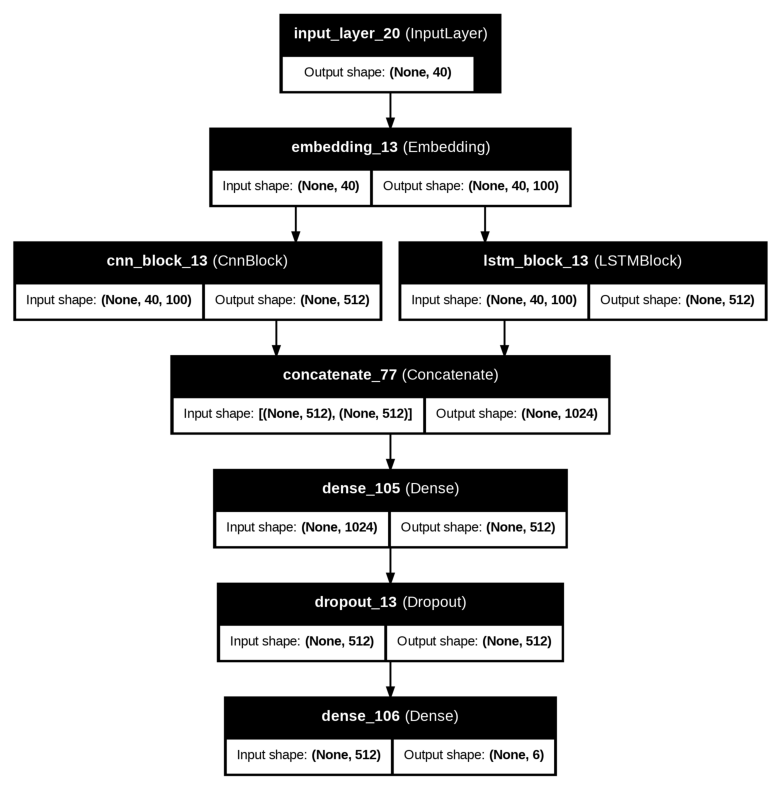

In [141]:
# Define Model
target = 6
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_config = (vocab_size, embedding_dim)
filters = 32
kernel_size = 3
lstm_unit = 64

model = Parallel_Cnn_Lstm_Model(target, maxlen, embedding_config, filters, kernel_size, lstm_unit)

model.build_graph().summary()
plot_model(model.build_graph(), to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
print("Model architecture saved as 'model_architecture.png'")

# Display the plot with a smaller figure size
img = mpimg.imread('model_architecture.png')
plt.figure(figsize=(10, 10))  # Adjust the size as needed
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

## **Step 4: Train model**

In [142]:
# Train Model
his, model = model_trainer(all_input_sequence_data, all_label, model,  epochs=100)

Step 4: Start training Model :)
Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5007 - loss: 1.6635 - precision_3: 0.6731 - recall_3: 0.2714 - val_accuracy: 0.8737 - val_loss: 0.4896 - val_precision_3: 0.8991 - val_recall_3: 0.8539 - learning_rate: 0.0010
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9132 - loss: 0.3394 - precision_3: 0.9282 - recall_3: 0.9010 - val_accuracy: 0.8857 - val_loss: 0.4342 - val_precision_3: 0.9002 - val_recall_3: 0.8728 - learning_rate: 0.0010
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9526 - loss: 0.1669 - precision_3: 0.9585 - recall_3: 0.9485 - val_accuracy: 0.8836 - val_loss: 0.3911 - val_precision_3: 0.8978 - val_recall_3: 0.8775 - learning_rate: 0.0010
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9739 - loss: 0.1097 - precision_3: 0.9780 - recall_3: 0.9703 - val_accuracy: 0.8892 - val_loss: 0.4291 - val_precision_3: 0.8947 - val_recall_3: 0.8845 - learning_r

## **Step 5: Evaluate model**

Step 5: Start evaluation model :)
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8974 - loss: 0.4694 - precision_3: 0.9024 - recall_3: 0.8945
---------------------------------------------
Test evaluation results:
---------------------------------------------
Loss: 0.4779
Compile_metrics: 0.8955


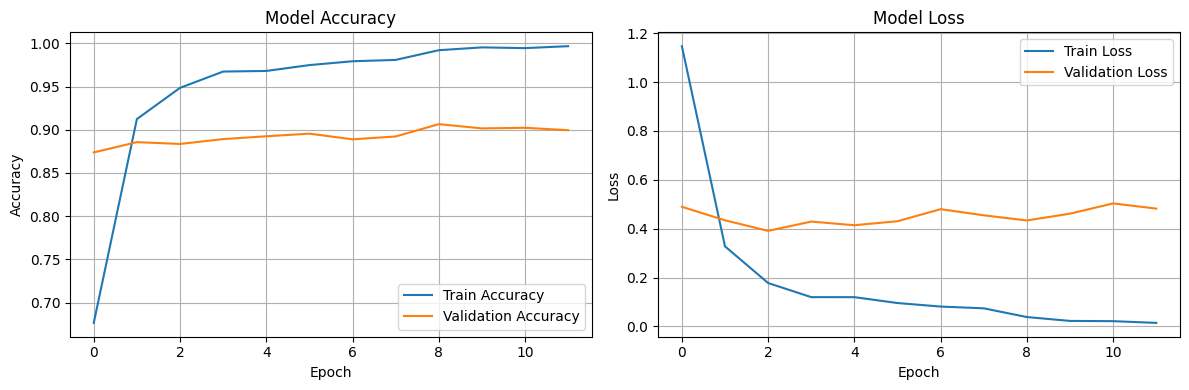

In [143]:
# Evaluate Model
model_evaluation(his, model, all_input_sequence_data, all_label)

# **Some test predictions**

In [144]:
import re
import nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

def data_preprocessor(sentences, tokenizer, type_padding='post', type_truncating='post', maxlen=40):
    """
    Preprocesses the input sentences for tokenization and padding, handling all stopwords except negations.

    Parameters:
    - sentences (list of str): The list of sentences to preprocess.
    - tokenizer (Tokenizer): The tokenizer to convert text to sequences.
    - type_padding (str): The type of padding ('pre' or 'post').
    - type_truncating (str): The type of truncating ('pre' or 'post').
    - maxlen (int): The maximum length of sequences after padding.

    Returns:
    - padded_sequences (numpy.ndarray): The padded sequences.
    - texts (list of str): The preprocessed texts.
    """

    # Load NLTK stopwords
    stopwords_list = set(stopwords.words('english'))

    # Define a list of negation words to be excluded from stopword removal
    negation_words = {'not', 'no', 'never', 'none', 'nothing', 'nobody', 'nowhere', 'neither', 'nor',
                      'don\'t', 'doesn\'t', 'didn\'t', 'can\'t', 'won\'t', 'wouldn\'t', 'shouldn\'t', 'mustn\'t'}

    # Lowercase all text
    texts = [sentence.lower() for sentence in sentences]

    # Remove stopwords except for negations
    texts = [' '.join(word for word in text.split() if word not in stopwords_list or word in negation_words) for text in texts]

    # Remove punctuation
    texts = [re.sub(r'[^\w\s]', '', text) for text in texts]

    # Remove digits
    texts = [re.sub(r'\d+', '', text) for text in texts]

    # Remove non-ASCII characters
    texts = [text.encode('ascii', 'ignore').decode('ascii') for text in texts]

    # Normalize whitespace
    texts = [' '.join(text.split()) for text in texts]

    # Print processed texts for debugging
    print(texts)

    # Convert text to sequences using tokenizer
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences
    padded_sequences = pad_sequences(sequences, padding=type_padding, truncating=type_truncating, maxlen=maxlen)

    return padded_sequences, texts


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [154]:
sentences = ["i am happy", "i am sad", "wow its amazing", "i will cray", "good man", "omg, incrediable"]
padded_sequences, texts = data_preprocessor(sentences, tokenizer, type_padding='post', type_truncating='post', maxlen=40)

['happy', 'sad', 'wow amazing', 'cray', 'good man', 'omg incrediable']


In [155]:
predicrions = model.predict_on_batch(padded_sequences)

In [156]:
le.classes_[np.argmax(predicrions, axis=1)]

array(['happy', 'sadness', 'surprise', 'anger', 'happy', 'anger'],
      dtype='<U8')